## Introduction

Puisque le "Big data" est un élément principal du monde de data science, j'ai décidé de regarder les moyens différents pour traiter les jeux de données qui sont trop grands pour être chargés en la mémoire de mon laptop.

Ce noteboook est le ***premier*** d'une série où je regarde des grands jeux de données, et cette fois-ci j'utiliserai le paramètre `chunksize` de la méthode `read_csv` de pandas pour traiter un fichier de grande taille. On peut trouver chaque notebook dans la série dans mon [répertoire Github](https://github.com/jlad26/london-smart-energy), y compris:
1. Pandas chunksize
1. Bibliothèque Dask

## Description du jeu de données

On se servira du jeu de données des [Données de consommation d'énergie des résidences muni de SmartMeter à Londres](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households), qui contient, selon le site web:
>Des relevés de consommation d'énergie pour un échantillon de 5 567 résidences à Londres qui ont participé au projet de Low Carbon London (géré par UK Power Networks) entre novembre 2011 et février 2014.

Les résidences étaient divisées en deux groupes:
- Celles qui ont reçu des tarifs d'énergie Dynamic Time of Use (dTou) (décrit "Haut", "Moyen", ou "Bas") la veille du jour où le prix allait être appliqué.
- Celles qui étaient soumises au tarif Standard.

Un but du projet était d'évaluer si la connaisance du prix de l'énergie changerait le comportement par rapport à la consommation d'énergie.

## Résultats

<img src="images/result1.png" width="100%"/>

Les résultats montrent la variation saisonnière attendue et une différence nette entre les deux groupes, qui suggère qu'une connaissance du prix d'énergie aide à réduire la consommation de l'énergie.

Le reste du notebook montre comment le diagramme était produit des données brutes.

## Accéder les données

On peut télécharger les données sous forme de fichier zip qui contient un fichier csv de 167 million lignes. Si la commande `curl` ne fonctionne pas (il faudra un certains temps puisque c'est un fichier de 800MB), vous pouvez télécharger le fichier [ici](https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip) et le mettre dans le dossier `data` qui se trouve dans le dossier où ce notebook est sauvegardé.

In [ ]:
!curl "https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip" --location --create-dirs -o "data/LCL-FullData.zip"

Ensuite on décompresse les données. Il faudra peut-être un certain temps! Vous pouvez également le décompresser manuellement en utilisant un autre logiciel de décompression. Assurez-vous simplement que vous mettez le fichier décompressé dans un dossier qui s'appelle `data` dans le dossier où votre notebook est sauvegardé.

In [1]:
!unzip "data/LCL-FullData.zip" -d "data"

Archive:  data/LCL-FullData.zip
  inflating: data/CC_LCL-FullData.csv  


## Examiner les données

In [2]:
import pandas as pd

La méthode conventionnelle pour charger le fichier csv serait `data = pd.read_csv('data/CC_LCL-FullData.csv')`, mais vu la taille du fichier de 8GB ce n'est pas faisable pour mon ordinateur. Donc à la place on va utiliser le paramètre `chunksize` qui charge les données par tranche ("chunk"). Chaque tranche contient le nombre précisé de lignes (sauf la dernière tranche). Les tranches sont identifiées comme des dataframes distincts qui sont référencés dans un objet `TextFileReader`.

On va charger notre fichier par tranche de 1 million de lignes.

In [3]:
chunks = pd.read_csv('data/CC_LCL-FullData.csv', chunksize=1000000)
type(chunks)

pandas.io.parsers.readers.TextFileReader

Veuillez noter que les données n'ont pas été chargées encore. Utiliser l'objet `TextFileReader` veut dire que les données sont traitées de manière "paresseuse" i.e. uniquement lorsqu'il est nécessaire. On peut itérer sur les tranches et les traiter une par une.

Examinons la première tranche, en utilisant les méthodes habituelles de `describe()`, `head()` et `info()`.

In [4]:
from IPython.display import HTML

table_style = [{
    'selector' : 'caption',
    'props' : [
        ('font-size', '16px'),
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('text-align', 'left')
    ]
}]

for chunk in chunks:
    
    display(
        chunk.describe(include='all')
        .style.set_caption('Describe')
        .set_table_styles(table_style)
    )
    
    display(
        chunk.head()
        .style.set_caption('Head')
        .set_table_styles(table_style)
    )
    
    display(HTML('<br><span style="font-weight: bold; font-size: 16px">Info</span>'))
    display(chunk.info())
    
    break # Just the first chunk

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
count,1000000,1000000,1000000,1000000
unique,30,1,39102,4801
top,MAC000018,Std,2012-11-20 00:00:00.0000000,0
freq,39082,1000000,58,45538


,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   LCLid                    1000000 non-null  object
 1   stdorToU                 1000000 non-null  object
 2   DateTime                 1000000 non-null  object
 3   KWH/hh (per half hour)   1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


None

La colonne `KWH/hh (per half hour)` est de type `object` et pas de type `float` qui est étonnant, donc sans doute il y a des valeurs non-numériques qu'on devra traiter.

## Pre-processing

On finira par renommer les colonnes pour les rendre plus lisibles, donc on définit les noms maintenant.

In [5]:
col_renaming = {
    'LCLid' : 'Household ID',
    'stdorToU' : 'Tariff Type',
    'KWH/hh (per half hour) ' : 'kWh'
}

Essayons de convertir les valuers de kWh en type numérique.

In [6]:
chunks = pd.read_csv('data/CC_LCL-FullData.csv', chunksize=1000000)
for chunk in chunks:
    chunk.rename(
        columns = col_renaming,
        inplace=True
    )
    chunk.loc[:, 'kWh'] = pd.to_numeric(chunk['kWh'])
    break

ValueError: Unable to parse string "Null" at position 3240

Le message d'erreur nous dit qu'il y a des valuers "Null" de type chaîne. Essayons de les supprimer de la première tranche pour tester la méthode.

In [7]:
test_chunks = pd.read_csv('data/CC_LCL-FullData.csv', chunksize=1000000)

for chunk in test_chunks:
    chunk.rename(columns=col_renaming, inplace=True)
    chunk.loc[:, 'kWh'] = pd.to_numeric(chunk['kWh'], errors='coerce')
    chunk.dropna(subset=['kWh'], inplace=True)
    print(f"{chunk.shape[0]} rows remaining after dropping rows where kWH is 'Null'")
    break

999971 rows remaining after dropping rows where kWH is 'Null'


On dirait que ça marche car maintenant on a moins de 1 000 000 lignes. Maintenant qu'on sait faire ça, on peut étudier comment créer des données utiles.

## Réduire les données

Le but est de ***réduire*** les données en les agrégant d'une manière ou d'une autre. Puisque nous savons que les données sont organisées par demi-heure, on va les agréger par jour en les additionnant sur chaque période de 24 heures. Cela devrait réduire le nombre de lignes par un facteur d' environ 48.

Quand je l'ai fait, j'ai testé en utilisant 2 tranches pour vérifier que tout fonctionnaient. Ainsi, j'ai pu construire la solution étape par étape, en ajoutant une autre méthode lorsque j'ai vu un bon résultat pour la transformation précédente. En itérant, pour chaque tranche les transformations sont comme suit:
1. Convertir les données de type horodatage en forme de date, prêt pour le regoupement
1. Renommer les colonnes
1. Convertir les valeurs kWh en valeurs numériques, en convertissant les erreurs en `Nan`
1. Supprimer les lignes où la valeur kWh est `NaN`
1. Agréger les données en les groupant par `Household ID`, `Tariff Type`, et `Date`, et en additionnant les valeurs `kWh` sur des périodes d'un jour
1. Additionner la tranche des données agrégées au total cumulé des données agrégées

In [8]:
def process_chunks(chunks, max_chunks=None, display_each_chunk=False):
    
    count = 1
    
    output = None
    
    for chunk in chunks:
    
        # Convert timestamp to date
        chunk['Date'] = pd.to_datetime(chunk['DateTime']).dt.date

        # Rename columns
        chunk.rename(columns=col_renaming, inplace=True)

        # Remove rows where kWh value is 'Null'
        chunk.loc[:, 'kWh'] = pd.to_numeric(chunk['kWh'], errors='coerce')
        chunk.dropna(subset=['kWh'], inplace=True)

        # Aggregate from half-hourly to daily kWh data
        daily_data = (
            chunk.groupby(
                by = ['Household ID', 'Tariff Type', 'Date']
            )
            .agg({
                'kWh' : 'sum'
            })
        )

        # Display for checking purposes
        if display_each_chunk:
            display(HTML(f'<span style="font-weight: bold; font-size: 16px">Chunk {count}</span>'))
            display(daily_data)
            print()

        # Add to running total
        if output is None:
            output = daily_data
        else:
            output = output.add(daily_data, fill_value=0)
            
        # Display progress every 10 chunks.
        if count % 10 == 0:
            print(count, end=', ')

        if max_chunks and count == max_chunks:
            break
        count += 1
        
    return output

In [9]:
chunks = pd.read_csv('data/CC_LCL-FullData.csv', chunksize=1000000)
test_daily_summary = process_chunks(chunks, 2, True)

# Display the aggregated totals
display(HTML(f'<span style="font-weight: bold; font-size: 16px">Total</span>'))
display(test_daily_summary)

kWh
Household ID Tariff Type Date              
MAC000002    Std         2012-10-12   7.098
                         2012-10-13  11.087
                         2012-10-14  13.223
                         2012-10-15  10.257
                         2012-10-16   9.769
...                                     ...
MAC000036    Std         2012-11-04   2.401
                         2012-11-05   2.379
                         2012-11-06   2.352
                         2012-11-07   2.599
                         2012-11-08   0.689

[20870 rows x 1 columns]

kWh
Household ID Tariff Type Date             
MAC000036    Std         2012-11-08  1.359
                         2012-11-09  2.659
                         2012-11-10  2.593
                         2012-11-11  2.542
                         2012-11-12  2.701
...                                    ...
MAC000069    Std         2013-05-08  4.385
                         2013-05-09  7.030
                         2013-05-10  7.033
                         2013-05-11  6.328
                         2013-05-12  3.923

[20861 rows x 1 columns]

kWh
Household ID Tariff Type Date              
MAC000002    Std         2012-10-12   7.098
                         2012-10-13  11.087
                         2012-10-14  13.223
                         2012-10-15  10.257
                         2012-10-16   9.769
...                                     ...
MAC000069    Std         2013-05-08   4.385
                         2013-05-09   7.030
                         2013-05-10   7.033
                         2013-05-11   6.328
                         2013-05-12   3.923

[41730 rows x 1 columns]

Maintenant on peut agréger toutes les données. Il faudra un certain temps pour le traitement! Le compteur montre le progrès en affichant la quantité de tranches traitées (par groupe de 10).

In [10]:
chunks = pd.read_csv('data/CC_LCL-FullData.csv', chunksize=1000000)
daily_summary = process_chunks(chunks)

# Display the aggregated totals
display(HTML(f'<span style="font-weight: bold; font-size: 16px">Total</span>'))
display(daily_summary)

10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 

kWh
Household ID Tariff Type Date              
MAC000002    Std         2012-10-12   7.098
                         2012-10-13  11.087
                         2012-10-14  13.223
                         2012-10-15  10.257
                         2012-10-16   9.769
...                                     ...
MAC005567    Std         2014-02-24   4.107
                         2014-02-25   5.762
                         2014-02-26   5.066
                         2014-02-27   3.217
                         2014-02-28   0.366

[3510403 rows x 1 columns]

## Sauvegarder les données agrégées

Maintentant qu'on a ramené les données à environ 3 millions lignes on devrait pouvoir les contenir dans un seul dataframe. Il vaut mieux les sauvegarder pour qu'on n'ait pas besoin de réexecuter l'agrégation chaque fois qu'on veut traiter les données.

On va le sauvegarder comme fichier compressé gz - pandas reconnait automatiquement le type de fichier quand on précise l'extension.

(On peut également utiliser le paramètre `chunksize` pour sauvegarder par tranche, mais ca ne devrait pas être nécessaire maintenant qu'on a réduit la taille.)

In [11]:
daily_summary.to_csv("data/daily-summary-data.gz")

## Analyser les données

On devrait pouvoir charger les données agrégées sans diviser en tranches.

In [12]:
saved_daily_summary = pd.read_csv("data/daily-summary-data.gz")

Vérifions s'il y a des résidences qui ont changé de groupe, puisque il serait intéressant de voir s'il y a un changement de comportement suite à un changement de groupe.

D'abord on agrège sur toute la période, en groupant par Household ID et Tariff Type.

In [13]:
kwh_by_household_and_tariff_type = saved_daily_summary.groupby(by=['Household ID', 'Tariff Type']).agg({
    'kWh' : 'sum'
})
kwh_by_household_and_tariff_type

,,kWh
Household ID,Tariff Type,
MAC000002,Std,6101.138001
MAC000003,Std,14104.433003
MAC000004,Std,1120.788000
MAC000005,ToU,2911.808000
MAC000006,Std,2168.325000
...,...,...
MAC005562,Std,6910.988999
MAC005564,ToU,2314.987999
MAC005565,ToU,5.790000


Maintenant on peut compter le nombre de tarifs d'énergie par résidence. On devrait voir soit 1 soit 2 pour chaque résidence. Ensuite on peut extraire les valeurs uniques...

In [14]:
tariff_types_by_household = kwh_by_household_and_tariff_type.groupby('Household ID').count()
tariff_types_by_household['kWh'].unique()

array([1], dtype=int64)

... et puisqu'on n'a que des valeurs de 1 on sait qu'aucun résidence a changé de tarif.

Donc à la place on va comparer les deux groupes côte à côte. Par intérêt examinons la couverture des données. D'abord on réorganise pour avoir les résidences en colonne et les date en ligne.

In [15]:
summary_table = daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Household ID',
    aggfunc='sum'
)

In [16]:
summary_table.head().dropna(axis=1)

Household ID,MAC000145,MAC000146,MAC000147,MAC000148,MAC000149,MAC000150,MAC000151,MAC000152,MAC000153,MAC000154,MAC000155,MAC000156,MAC000157
Date,,,,,,,,,,,,,
2011-11-23,8.952,5.619,3.036,1.283,2.287,9.254,3.273,5.969,21.702,5.798,9.281,6.523,7.408
2011-11-24,12.135,8.564,7.489,2.304,4.331,9.606,4.620,8.394,29.722,10.879,14.481,12.689,14.258
2011-11-25,13.720,6.743,6.185,2.324,4.373,12.685,4.783,7.898,30.071,9.579,13.689,10.717,14.818
2011-11-26,15.234,6.029,6.964,2.295,4.335,9.606,4.935,9.074,33.384,10.348,16.080,12.442,11.265
2011-11-27,13.189,5.740,7.912,2.302,4.375,14.387,4.553,9.421,34.204,8.905,16.060,12.964,12.328


Ensuite on peut afficher où on a des données (noir) et où on n'en a pas (blanc).

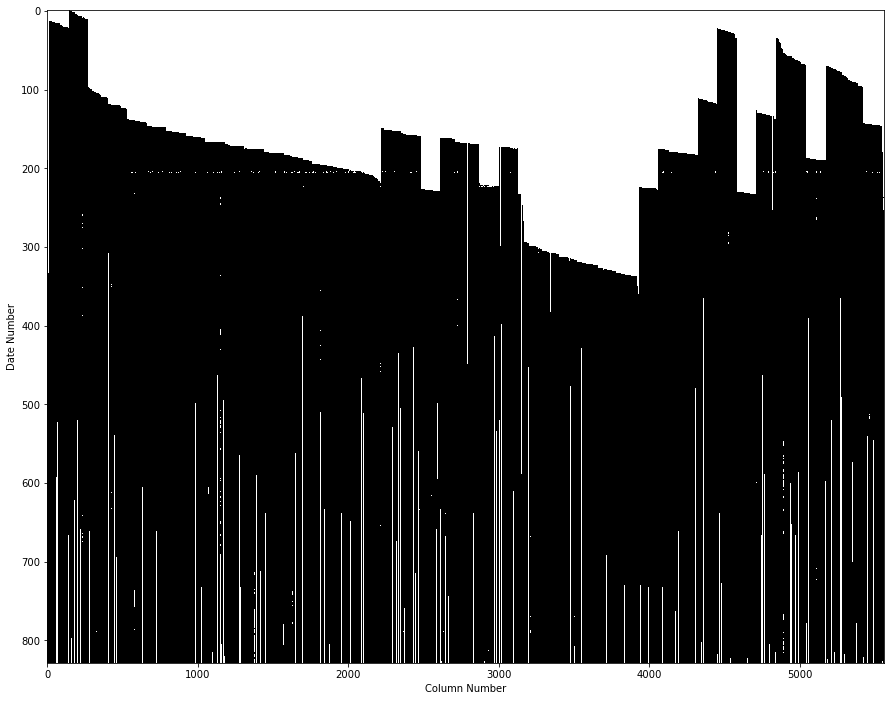

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.imshow(summary_table.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Date Number");

Malgré une couverture un peu lacunaire, calculer par tarif sur toutes les résidences par jour devrait nous donner une comparaison utile.

In [18]:
daily_mean_by_tariff_type = daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Tariff Type',
    aggfunc='mean'
)
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


Finalement on peut tracer les deux groupes de données. Le traçage marche mieux si on convertit la date de type `string` en type `datetime`.

In [19]:
daily_mean_by_tariff_type.index = pd.to_datetime(daily_mean_by_tariff_type.index)

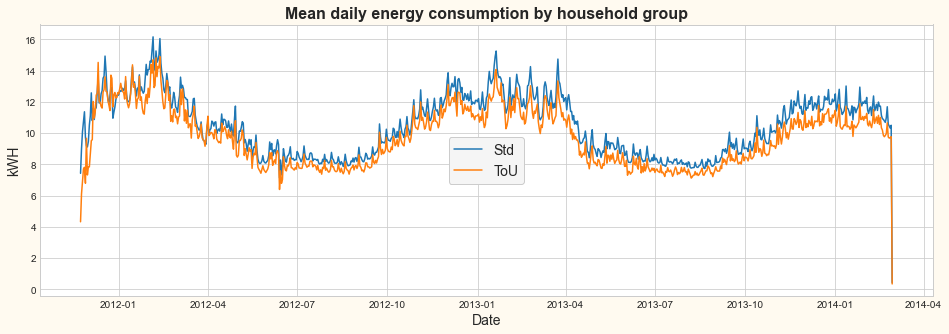

In [20]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        daily_mean_by_tariff_type.index.values,
        daily_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='center', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Mean daily energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)
plt.show()

On dirait que la variation est saisonnière qui n'est pas étonnant vu la demande d'énergie de chauffage.

On dirait aussi qu'il y a une différence entre les deux groupes: le groupe ToU a l'air de consommer moins, mais l'affichage est trop granulaire pour voir bien. Agégeons encore une fois, cette fois-ci par mois.

In [21]:
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


On voit que les données commencent au cours de novembre 2011, donc on commencera le 1 décembre. On dirait que les données terminent parfaitement à la fin de février, mais la dernière valeur est suspecte puisqu'elle est très basse comparé aux autres. Il paraît probable que les données ont terminé au cours de la dernière journée, donc on finira à la fin de janvier. Peut-être qu'on a le même problème ailleurs dans les données, mais l'effet ne devrait pas être énorme parce que dans le pire des cas la consommation mensuelle d'une résidence sera réduite par deux journées (une au début et une à la fin).

In [22]:
monthly_mean_by_tariff_type = daily_mean_by_tariff_type['2011-12-01' : '2014-01-31'].resample('M').sum()
monthly_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-12-31,377.443042,365.391597
2012-01-31,401.744672,386.253703
2012-02-29,395.294296,368.663764
2012-03-31,349.367317,331.095386
2012-04-30,314.323216,297.032370
2012-05-31,281.796440,263.812879
2012-06-30,257.333248,238.532452
2012-07-31,260.359313,244.757999
2012-08-31,254.085724,239.041805


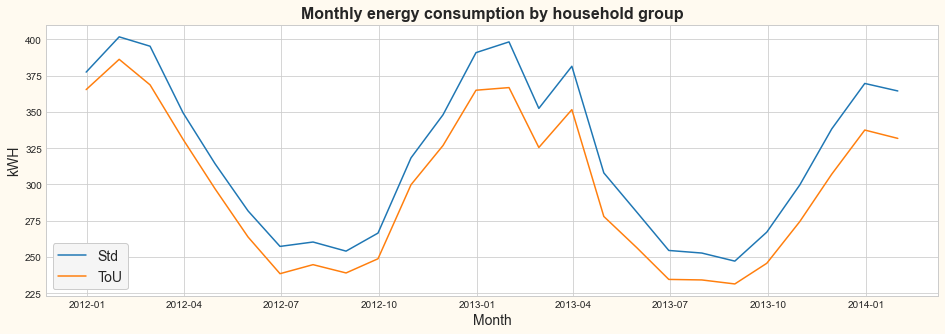

In [23]:
plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        monthly_mean_by_tariff_type.index.values,
        monthly_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='lower left', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Monthly energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)

# Uncomment for a copy to display in results
# plt.savefig(fname='images/result1.png', bbox_inches='tight')

plt.show()

Le diagramme est plus clair et il y a une différence evidente entre les deux groupes.

Veuillez noter que le diagramme ne montre pas la consommation mensuelle moyenne. Il montre la somme des moyennes journalières pour chaque mois. Pour calculer les vraies moyennes mensuelles on aurait besoin d'exclure les données journalières pour chaque résidence pendant les mois où les données n'étaient pas complètes. Notre méthode plus simple devrait nous donner une bonne approximation.